In [ ]:
# default_cls_lvl 3

# General Camera Calibration
> Utilities for calibrating a cameras and pairs 
>

### Setup
To run these examples Install Jupyter Notebook  
`pip install notebook`

In [ ]:
from nbdev.showdoc import *
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import cv2

In [ ]:
def show_img(im, figsize=None, ax=None, alpha=None, label=None, mode=None, axis_on=False, title=None, cmap=None, vmin=0, vmax=None):
    if not ax: fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha, cmap=cmap, vmin=vmin, vmax=vmax)
    if not axis_on:
        ax.set_axis_off()
    if label: ax.legend()
    if title: ax.set_title(title)
    return ax


### Camera Calibration.
Measure  distortions in camera, intrinsic and extrinsic parameters of camera etc.  
We will learn to find these parameters, undistort images etc.  
Basics  
https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html#calibration  


Left and right camera samples are in the local `nbs\sample_data\` directory. 

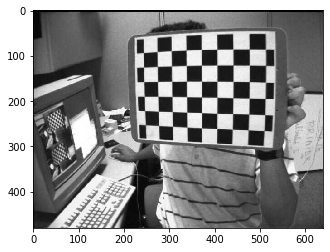

In [ ]:
import cv2
cv2.samples.addSamplesDataSearchPath('sample_data')
src2 = cv2.imread(cv2.samples.findFile('left01.jpg'))
imshow(src2)

### Find chess board image corner points points
To find pattern in chess board, we use the function, cv2.findChessboardCorners()  
Pass what kind of pattern we are looking, like 8x8 grid, 5x5 grid etc. In this example, we use 7x6 grid. 
Once we find the corners, we can increase their accuracy using cv2.cornerSubPix().  

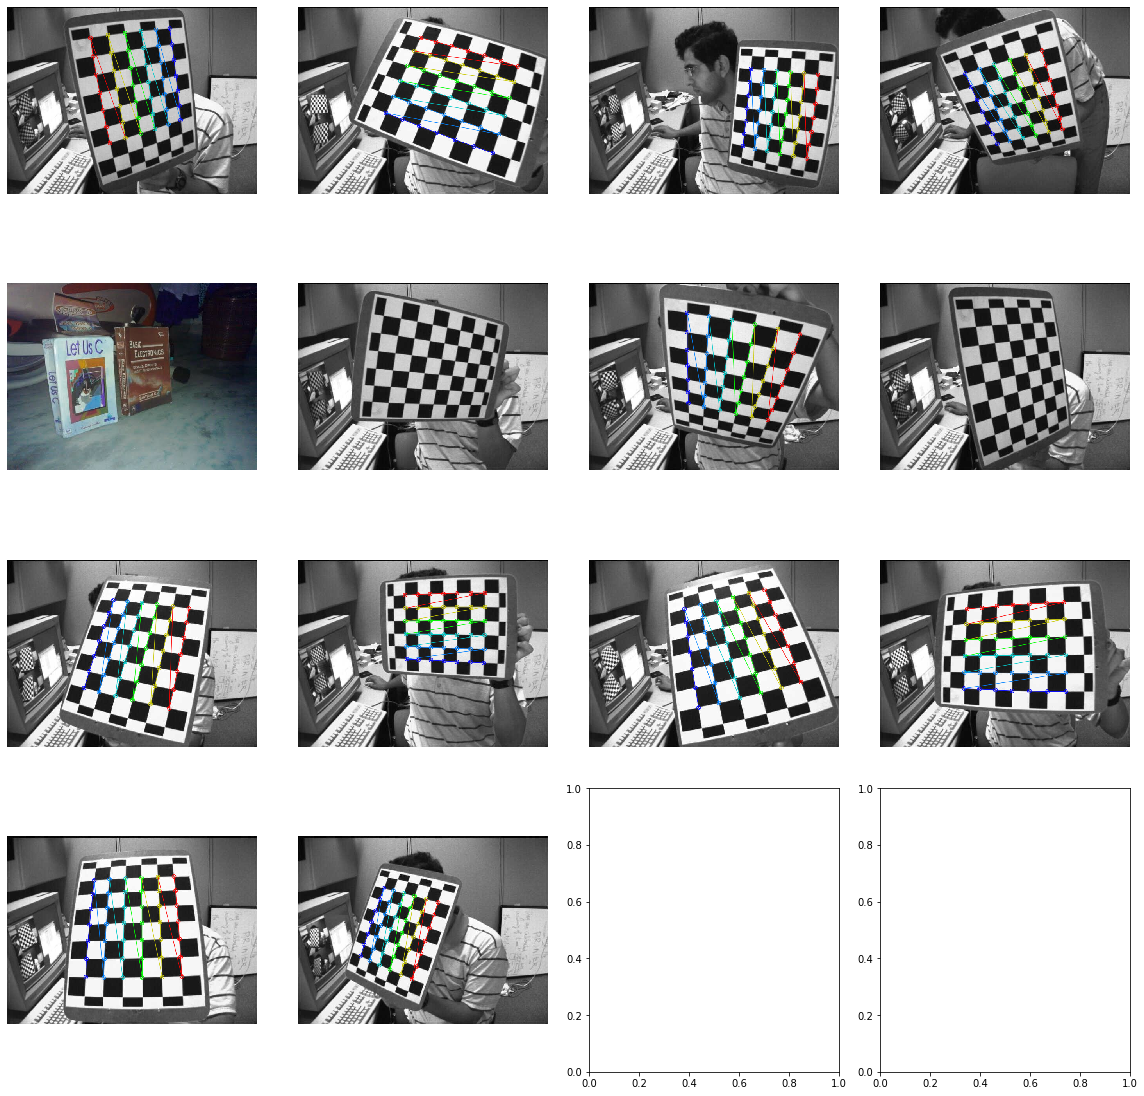

In [ ]:
import numpy as np
import cv2
import glob

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

fig, axes = plt.subplots(4, 4, figsize=(16, 16))
images = glob.glob('sample_data/left*.jpg')

for i, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (7,6),None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (7,6), corners2,ret)
        # cv2.imshow('img',img)
        # cv2.waitKey(500)
         
    show_img(img, ax=axes.flat[i])

cv2.destroyAllWindows()
plt.tight_layout()

### Calibration
The function cv2.calibrateCamera() returns the camera matrix, distortion coefficients, rotation and translation vectors etc.

In [ ]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

len(rvecs)

11

### Undistortion

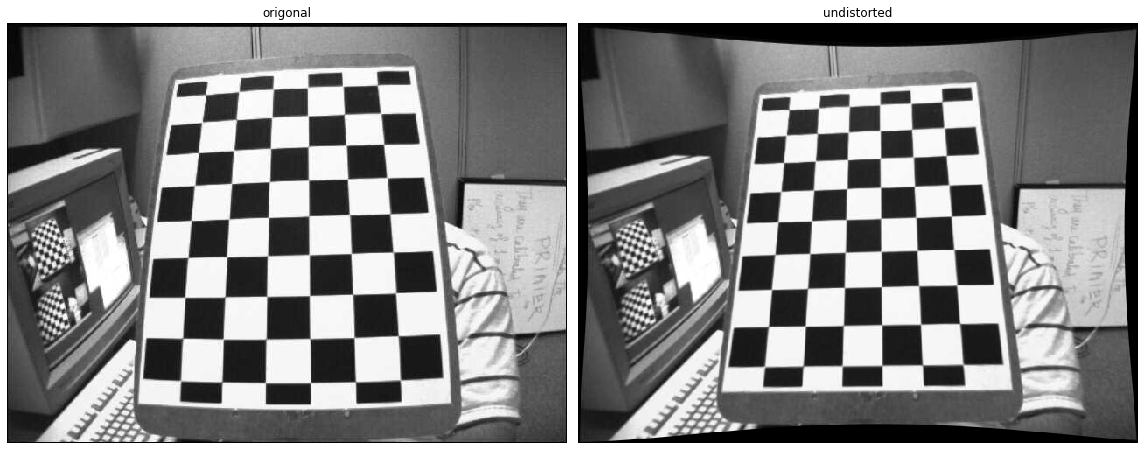

In [ ]:
img = cv2.imread('sample_data/left12.jpg')
h,  w = img.shape[:2]
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))

dst = cv2.undistort(img, mtx, dist, None, newcameramtx)

# crop the image
# x,y,w,h = roi
# dst = dst[y:y+h, x:x+w]
# cv2.imwrite('calibresult.png',dst)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
show_img(img, ax=ax1, title='origonal')
show_img(dst, ax=ax2, title='undistorted')
plt.tight_layout()

### Using remapping
First find a mapping function from distorted image to undistorted image. Then use the remap function.
Then use the undistorted pixels x,y to select the mapping pixel from the distorted image

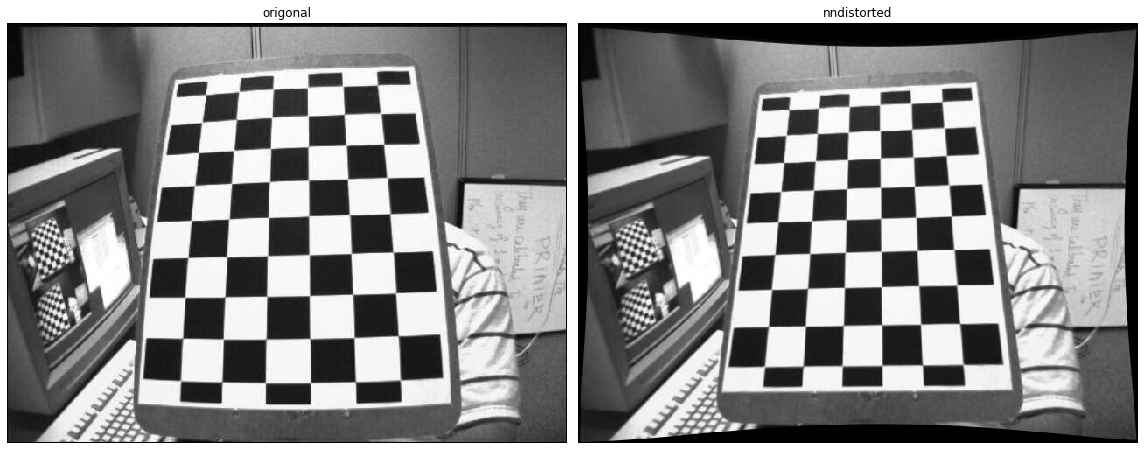

In [ ]:
# undistort
mapx,mapy = cv2.initUndistortRectifyMap(mtx,dist,None,newcameramtx,(w,h),5)
dst = cv2.remap(img,mapx,mapy,cv2.INTER_LINEAR)

# crop the image
# x,y,w,h = roi
# dst = dst[y:y+h, x:x+w]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
show_img(img, ax=ax1, title='origonal')
show_img(dst, ax=ax2, title='nndistorted')
plt.tight_layout()

### Re-projection Error
Re-projection error gives a good estimation of just how exact is the found parameters. This should be as close to zero as possible.

In [ ]:
mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpoints[i],imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    mean_error += error

print ("total error: ", mean_error/len(objpoints))
print('len(objpoints): ', len(objpoints))

total error:  0.023686004734391333
len(objpoints):  11


###  Create a depth map from stereo images

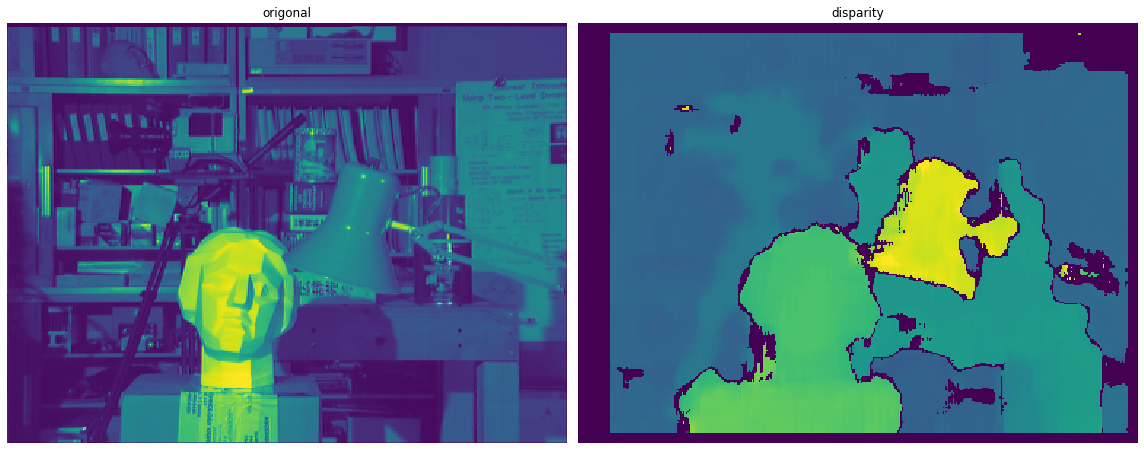

In [ ]:
import numpy as np

from matplotlib import pyplot as plt
imgL = cv2.imread('sample_data/tsukuba_l.png', cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread('sample_data/tsukuba_r.png', cv2.IMREAD_GRAYSCALE)
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
disparity = stereo.compute(imgL,imgR)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
show_img(imgL, ax=ax1, title='origonal')
show_img(disparity, ax=ax2, title='disparity')
plt.tight_layout() 